In [1]:
# Import Libraries

from statsbombpy import sb

## Math Operations
import numpy as np
import math

## Data Preprocessing
import pandas as pd

## Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import to_rgba
from matplotlib import rcParams
import seaborn as sns
import networkx as nx
from PIL import Image
from highlight_text import ax_text, fig_text
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen
import mplsoccer
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

## Requests and downloads
import tqdm
import requests
from urllib.request import urlopen

## Filter warning
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# get event dataframe for game 3795506
parser = Sbopen()
events, related, freeze, players = parser.event(3795506)

In [3]:
# set team and opponent
TEAM = 'England'
OPPONENT = 'versus Italy, Euro 2020 Final'

In [4]:
# take data about tactics
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[events.tactics_formation.notnull(), 'id']

events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[['tactics_id', 'tactics_formation']].ffill()

In [5]:
# player definition and position
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}

players['position_abbreviation'] = players.position_id.map(formation_dict)

In [6]:
# get info about substitutions
sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]

players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')

players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))

players = pd.concat([players, players_sub])

players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)

players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [7]:
# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')

# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                     axis='columns'), on=['tactics_id', 'pass_recipient_id'],
                                      how='left', validate='m:1', suffixes=['', '_receipt'])

In [8]:
events.groupby('team_name').tactics_formation.unique()

team_name
England    [3421.0, 4231.0, 433.0]
Italy                      [433.0]
Name: tactics_formation, dtype: object

In [9]:
FORMATION = 3421
pass_cols = ['id', 'position_abbreviation', 'position_abbreviation_receipt']
passes_formation = events.loc[(events.team_name == TEAM) & (events.type_name == 'Pass') &
                              (events.tactics_formation == FORMATION) &
                              (events.position_abbreviation_receipt.notnull()), pass_cols].copy()
location_cols = ['position_abbreviation', 'x', 'y']
location_formation = events.loc[(events.team_name == TEAM) &
                                (events.type_name.isin(['Pass', 'Ball Receipt'])) &
                                (events.tactics_formation == FORMATION), location_cols].copy()

# average locations
average_locs_and_count = (location_formation.groupby('position_abbreviation')
                          .agg({'x': ['mean'], 'y': ['mean', 'count']}))
average_locs_and_count.columns = ['x', 'y', 'count']

# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .max(axis='columns'))

passes_formation['pos_min'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .min(axis='columns'))

passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# add on the location of each player so we have the start and end positions of the lines
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True,
                                      suffixes=['', '_end'])

In [10]:
# set line width and marker size
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000

passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                           MAX_LINE_WIDTH)

average_locs_and_count['marker_size'] = (average_locs_and_count['count']
                                         / average_locs_and_count['count'].max() * MAX_MARKER_SIZE)

In [11]:
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))

c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY

color[:, 3] = c_transparency

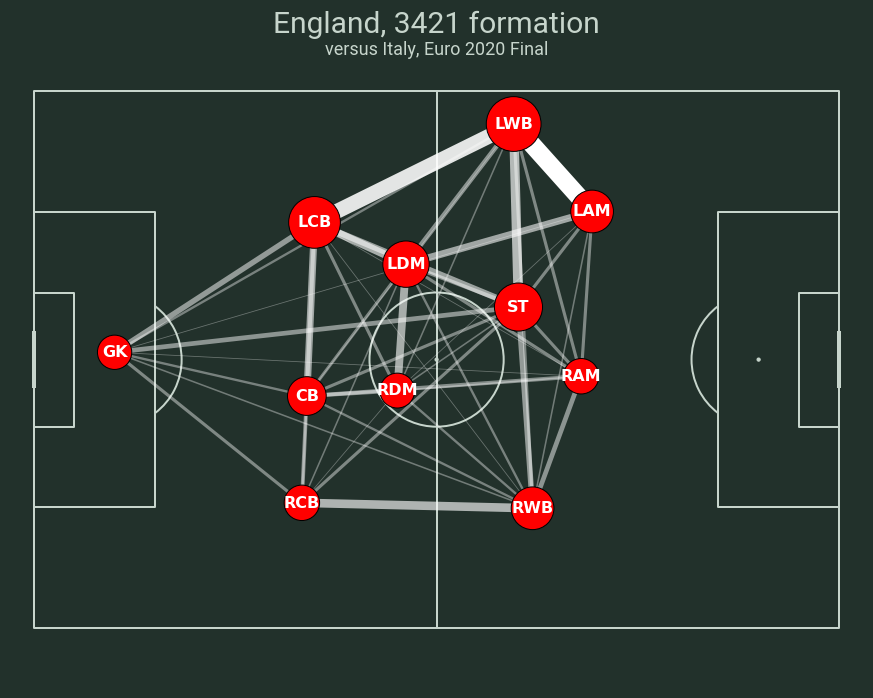

In [12]:
# Plot the pass network for England team 

pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')

fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False,
                      title_space=0, grid_height=0.82, endnote_height=0.05)
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=axs['pitch'])

pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y,
                           s=average_locs_and_count.marker_size,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])

for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=axs['pitch'])

# Load a custom font.
URL = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
robotto_regular = FontManager(URL)

# add title
TITLE_TEXT = f'{TEAM}, {FORMATION} formation'
axs['title'].text(0.5, 0.7, TITLE_TEXT, color='#c7d5cc',
                  va='center', ha='center', fontproperties=robotto_regular.prop, fontsize=30)
axs['title'].text(0.5, 0.25, OPPONENT, color='#c7d5cc',
                  va='center', ha='center', fontproperties=robotto_regular.prop, fontsize=18)


#plt.show()
plt.savefig("ENG_passnet.jpg", bbox_inches = 'tight')